## SJM-BL Simulation study (scenario 1)
### 1.0 Loading packages

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For HMM and model training
from hmmlearn.hmm import GaussianHMM
from sklearn.cluster import KMeans
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from scipy.optimize import linear_sum_assignment
from scipy.stats import wilcoxon
from joblib import Parallel, delayed

# Import jumpmodels (including our custom preprocess functions)
from jumpmodels.sparse_jump import SparseJumpModel
from jumpmodels.preprocess import StandardScalerPD, DataClipperStd
import scipy.stats as stats
from jumpmodels.plot import plot_regimes_and_cumret, savefig_plt

# Importing Portfolio Packages
from pypfopt.black_litterman import BlackLittermanModel, market_implied_risk_aversion
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import base_optimizer, expected_returns, risk_models

# Asset names and seed for reproducibility
assets = ["Value", "Growth", "LowVol", "Size", "Momentum", "Quality"]
n_assets = len(assets)
rng = np.random.default_rng(42)

### 2.0 Data Simulation

#### 2.1 Simulating the 1-state data
We are simulating 6 fictional assets which are representing the 6 factors in our framework
- **1-State:** A single regime with Student‑t returns.
- **2-State:** A two-regime (bull/bear) HMM with state-dependent parameters.
- **3-State:** A three-regime HMM with specified means and volatilitie

All assets have the same expected return and volatility.

In [50]:
# Define asset names and seed RNG for reproducibility.
assets = ["Value", "Growth", "LowVol", "Size", "Momentum", "Quality"]
n_assets = len(assets)
rng = np.random.default_rng(42)  # random seed
CONST_RET = 0.000461


In [51]:
def simulate_1state_data(T):
    """
    1-state model: returns follow a Student-t distribution.
    """
    mu = 0.000461
    sig = 0.008388
    dof = 5
    # Create a correlation matrix with off-diagonals = 0.185
    corr = np.full((n_assets, n_assets), 0.185)
    np.fill_diagonal(corr, 1.0)  # set diagonals to 1
    Cov = (sig * np.ones(n_assets))[:, None] @ (sig * np.ones(n_assets))[None, :] * corr

    # Generate multivariate draws and scale using chi-square factor
    z = rng.multivariate_normal(mean=np.zeros(n_assets), cov=Cov, size=T)
    chi = rng.chisquare(dof, size=T)
    factor = np.sqrt(dof / chi)
    rets = mu + z * factor[:, np.newaxis]

    return pd.DataFrame(rets, columns=assets)

#### 2.2 Simulating 2-state data

This function simulates a 2-state HMM (bull/bear) with state‐dependent Student‑t returns.

In [52]:
def simulate_2state_data(T):
    """
    2-state HMM: bull and bear regimes.
    """
    transmat = np.array([[0.9976, 0.0024],
                         [0.0232, 0.9768]])
    states = np.zeros(T, dtype=int)
    states[0] = rng.integers(2)  # random starting state
    for t in range(1, T):
        states[t] = rng.choice(2, p=transmat[states[t - 1]])

    mu_dict = {0: 0.0006, 1: -0.000881}
    sig_dict = {0: 0.00757, 1: 0.0163}
    corr = np.full((n_assets, n_assets), 0.185)
    np.fill_diagonal(corr, 1.0)

    rets = np.zeros((T, n_assets))
    dof = 5
    for t in range(T):
        s = states[t]
        mu_s = np.full(n_assets, mu_dict[s])
        sig_s = np.full(n_assets, sig_dict[s])
        Cov_s = np.outer(sig_s, sig_s) * corr
        z = rng.multivariate_normal(mean=np.zeros(n_assets), cov=Cov_s)
        chi = rng.chisquare(dof)
        factor = np.sqrt(dof / chi)
        rets[t] = mu_s + factor * z

    return pd.DataFrame(rets, columns=assets), states

#### 2.3 Simulating 3-state data

We are simulating 6 fictional assets which are representing the 6 factors in our framework

In [53]:
def simulate_3state_data(T):
    """
    3-state HMM: three regimes with specified means and volatilities.
    """
    transmat = np.array([[0.998900, 0.000400, 0.000700],
                         [0.008900, 0.990400, 0.000700],
                         [0.008900, 0.000400, 0.990700]])
    states = np.zeros(T, dtype=int)
    states[0] = rng.integers(3)
    for t in range(1, T):
        states[t] = rng.choice(3, p=transmat[states[t - 1]])

    mu_list = [0.0008, 0.0, -0.003586]
    sig_list = [0.0070, 0.0050, 0.01897]
    corr = np.full((n_assets, n_assets), 0.185)
    np.fill_diagonal(corr, 1.0)

    rets = np.zeros((T, n_assets))
    dof = 5
    for t in range(T):
        s = states[t]
        mu_s = np.full(n_assets, mu_list[s])
        sig_s = np.full(n_assets, sig_list[s])
        Cov_s = np.outer(sig_s, sig_s) * corr
        z = rng.multivariate_normal(mean=np.zeros(n_assets), cov=Cov_s)
        chi = rng.chisquare(dof)
        factor = np.sqrt(dof / chi)
        rets[t] = mu_s + factor * z

    return pd.DataFrame(rets, columns=assets), states

### 3.0 Training Regime Models

#### 3.1 Training HMM using kmeans clustering initialization

In [54]:
def train_hmm_kmeans(X, n_components=2, random_state=42):
    """
    Fit a GaussianHMM using k-means for initialization.
    """
    model = GaussianHMM(n_components=n_components, covariance_type="diag",
                        n_iter=100, random_state=random_state)
    kmeans = KMeans(n_clusters=n_components, n_init=10, random_state=random_state)
    labels = kmeans.fit_predict(X)
    means, covars = [], []
    for i in range(n_components):
        obs_i = X[labels == i]
        means.append(obs_i.mean(axis=0))
        covars.append(obs_i.var(axis=0) + 1e-2)
    # Set HMM parameters
    model.startprob_ = np.ones(n_components) / n_components
    model.transmat_ = np.ones((n_components, n_components)) / n_components
    model.means_ = np.array(means)
    model.covars_ = np.array(covars)
    model.init_params = 'tmc'

    model.fit(X)
    pred_states = model.predict(X)
    return model, pred_states

#### 3.2 Training Sparse Jump model with max_feats=9 and lambda=80
##### 3.2.1 Defining feature selection framework

In [55]:
def standardize_features(X):
    X_df = pd.DataFrame(X)
    clipper = DataClipperStd(mul=3.0)  # clip outliers
    scaler = StandardScalerPD()        # standardize data
    X_clipped = clipper.fit_transform(X_df)
    X_scaled = scaler.fit_transform(X_clipped)
    return X_scaled.values


def compute_temporal_features(y, l):
    """
    Compute 9 temporal features using a window of length l.
    """
    T = len(y)
    feats = np.zeros((T, 9), dtype=float)
    half = (l - 1) // 2
    for t in range(T):
        feats[t, 0] = y[t]
        feats[t, 1] = abs(y[t] - y[t-1]) if t > 0 else 0.
        feats[t, 2] = abs(y[t+1] - y[t]) if t < (T-1) else 0.
        left_c = max(0, t - half)
        right_c = min(T, t + half + 1)
        window_c = y[left_c:right_c]
        feats[t, 3] = np.mean(window_c)
        feats[t, 4] = np.std(window_c)
        left_l = max(0, t - l)
        right_l = t
        window_l = y[left_l:right_l]
        feats[t, 5] = np.mean(window_l) if len(window_l) > 0 else 0.
        feats[t, 6] = np.std(window_l) if len(window_l) > 0 else 0.
        left_r = t
        right_r = min(T, t + l)
        window_r = y[left_r:right_r]
        feats[t, 7] = np.mean(window_r) if len(window_r) > 0 else 0.
        feats[t, 8] = np.std(window_r) if len(window_r) > 0 else 0.
    return feats


def combine_features(y, l_list=[5, 13]):
    feat_list = []
    for l in l_list:
        feat_list.append(compute_temporal_features(y, l))
    return np.hstack(feat_list)

In [56]:
def train_sjm(X, max_feats=9.0, lam=80.0, n_components=2, random_state=42):
    sjm = SparseJumpModel(n_components=n_components,
                          max_feats=max_feats,
                          jump_penalty=lam,
                          cont=False,
                          max_iter=20,
                          random_state=random_state)
    sjm.fit(X)
    return sjm

### 4.0 Allocation simulation

#### 4.1 Allocation workhorse functions
In this code we create the in which we fit the following models (each done in a seperate for loop such that we can store the relevant data such as return, weights, etc. in seperate dfs):
1. Equal weigted
2. Inverse volatility weighted
3. Mean-Variance-Optimal static portfolio
4. Hidden Markov Model Black Litterman where infered states are the identified regimes
5. Sparse Jump Model Black Litterman where infered states are the identified regimes

In [57]:
RISK_FREE_RATE = 0.02 / 252
TRANSACTION_COST = 0.0005
BL_TAU = 0.05

def static_mvo_allocation(returns):
    """
    Mean-Variance-Optimal static portfolio using a constant prior expected return.
    """
    # Constant mu for each asset
    mu = pd.Series(CONST_RET, index=returns.columns)
    S = risk_models.sample_cov(returns)
    # small diagonal loading
    S_reg = S + 1e-6 * np.eye(S.shape[0])
    ef = EfficientFrontier(mu, S_reg, weight_bounds=(0, 1), solver="SCS")
    weights = ef.max_sharpe(risk_free_rate=RISK_FREE_RATE)
    return ef.clean_weights()

def inverse_vol_weights(returns):
    stds = returns.std(axis=0).values
    inv = 1.0 / (stds + 1e-12)
    return inv / inv.sum()

def backtest_portfolio(returns, weights):
    T = len(returns)
    pv = np.zeros(T)
    pv[0] = 1.0
    for t in range(T - 1):
        r = returns.iloc[t].values
        pv[t + 1] = pv[t] * (1.0 + np.dot(weights, r))
    return pv

def bl_allocation(view_vector, prior_cov):
    """
    Compute BL allocation with constant prior returns for all assets = CONST_RET.
    """
    pi = pd.Series(CONST_RET, index=prior_cov.columns)
    viewdict = {asset: view for asset, view in zip(assets, view_vector)}

    bl = BlackLittermanModel(
        cov_matrix=prior_cov,
        pi=pi,  # custom prior
        absolute_views=viewdict,
        tau=BL_TAU,
        risk_aversion=1
    )
    weights = bl.bl_weights()
    return np.array([weights[asset] for asset in assets])

def regime_based_bl_backtest(returns, states, regime_mu_dict, prior_cov):
    T = len(returns)
    n = returns.shape[1]
    pv = np.zeros(T)
    pv[0] = 1.0
    w_hist = np.zeros((T, n))
    w_hist[0] = np.ones(n) / n

    for t in range(T - 1):
        r = returns.iloc[t].values
        pv[t + 1] = pv[t] * (1.0 + np.dot(w_hist[t], r))

        # Re-allocate only if regime changed (or first day)
        if t == 0 or (states[t] != states[t - 1]):
            Q = regime_mu_dict[states[t]]
            w_new = bl_allocation(Q, prior_cov)
        else:
            w_new = w_hist[t]

        w_hist[t + 1] = w_new

        # Transaction cost
        if t > 0:
            turnover = np.sum(np.abs(w_hist[t + 1] - w_hist[t]))
            cost = TRANSACTION_COST * turnover
        else:
            cost = 0.0
        pv[t + 1] *= (1.0 - cost)

    # Final day
    r_last = returns.iloc[-1].values
    pv[-1] = pv[-2] * (1.0 + np.dot(w_hist[-2], r_last))
    return pv, w_hist

### 5.0 Performance metric evaluation:
Here we divide the performance metric into. We assume 250 data points to be 1 year off trading:
1. Return-Based Metrics 

Annualized Return: Average return per year. 

Cumulative Return: Total portfolio growth over time. 

2. Risk-Based Metrics 

Volatility: Standard deviation of returns. 

Downside Deviation: Measures negative return fluctuations. 

Max Drawdown (MDD): Largest portfolio decline from peak to trough. 

3. Risk-Adjusted Metrics 

Sharpe Ratio: Return per unit of total risk. 

Sortino Ratio: Return per unit of downside risk. 

Calmar Ratio: Return relative to max drawdown. 

4. Portfolio Stability & Adaptation 

Turnover Rate: Measures frequency of asset reallocation. 


We further split the performance three seperate tables with 1-state process, 2-state process, 3-state process




In [58]:
def compute_performance_metrics(pv, weight_history=None, annual_factor=250):
    pv = np.array(pv)
    rets = np.diff(pv) / pv[:-1]

    ann_ret = rets.mean() * annual_factor
    cum_ret = pv[-1] / pv[0] - 1
    ann_vol = rets.std() * np.sqrt(annual_factor)

    negative_rets = rets[rets < 0]
    downside_dev = negative_rets.std() * np.sqrt(annual_factor) if len(negative_rets) else 0.0

    running_max = np.maximum.accumulate(pv)
    drawdown = (pv - running_max) / running_max
    max_dd = drawdown.min()

    sharpe = ann_ret / (ann_vol + 1e-12)
    sortino = ann_ret / downside_dev if downside_dev > 1e-12 else np.nan
    calmar = ann_ret / abs(max_dd) if max_dd < 0 else np.nan

    # Turnover
    if weight_history is not None and len(weight_history) > 1:
        turnover_list = []
        for t in range(1, len(weight_history)):
            turnover_list.append(np.sum(np.abs(weight_history[t] - weight_history[t - 1])))
        avg_turnover = np.mean(turnover_list)
    else:
        avg_turnover = 0.0

    return {
        "Annualized Return": ann_ret,
        "Cumulative Return": cum_ret,
        "Volatility": ann_vol,
        "Downside Deviation": downside_dev,
        "Max Drawdown": max_dd,
        "Sharpe Ratio": sharpe,
        "Sortino Ratio": sortino,
        "Calmar Ratio": calmar,
        "Turnover Rate": avg_turnover,
    }

#### 6.0 Simulation

In [59]:
def run_allocation(df, states=None, scenario_name=""):
    """
    1) Equal weight
    2) Inverse volatility
    3) Static MVO (uses CONST_RET)
    4) HMM-BL
    5) SJM-BL
    """
    split_idx = int(len(df) * 0.8)
    df_train = df.iloc[:split_idx]
    df_test = df.iloc[split_idx:]

    # Preprocessing
    clipper = DataClipperStd(mul=3.0)
    scaler = StandardScalerPD()
    df_train_clipped = clipper.fit_transform(df_train)
    df_train_scaled = scaler.fit_transform(df_train_clipped)
    X_train = df_train_scaled.values

    df_test_clipped = clipper.transform(df_test)
    df_test_scaled = scaler.transform(df_test_clipped)
    X_test = df_test_scaled.values

    # Train 2-state HMM
    hmm_model, hmm_states_train = train_hmm_kmeans(X_train, n_components=2, random_state=42)
    # Train 2-state SJM
    sjm_model = train_sjm(X_train, max_feats=9.0, lam=80.0, n_components=2, random_state=42)

    def get_regime_means(df_orig, labels):
        regs = {}
        for lab in np.unique(labels):
            idx = np.where(labels == lab)[0]
            regs[lab] = df_orig.iloc[idx].mean(axis=0).values
        return regs

    hmm_mu = get_regime_means(df_train, hmm_states_train)
    sjm_mu = get_regime_means(df_train, sjm_model.predict(X_train))

    prior_cov = df_train.cov()

    # --- Strategy 1: Equal Weight
    w_ew = np.ones(n_assets) / n_assets
    pv_ew = backtest_portfolio(df_test, w_ew)
    w_hist_ew = np.tile(w_ew, (len(df_test), 1))

    # --- Strategy 2: Inverse Vol
    w_iv = inverse_vol_weights(df_test)
    pv_iv = backtest_portfolio(df_test, w_iv)
    w_hist_iv = np.tile(w_iv, (len(df_test), 1))

    # --- Strategy 3: Static MVO
    w_mvo_dict = static_mvo_allocation(df_test)
    w_mvo_arr = np.array([w_mvo_dict[asset] for asset in assets])
    pv_mvo = backtest_portfolio(df_test, w_mvo_arr)
    w_hist_mvo = np.tile(w_mvo_arr, (len(df_test), 1))

    # --- Strategy 4: HMM-BL
    hmm_test_states = hmm_model.predict(X_test)
    pv_hmmbl, w_hist_hmmbl = regime_based_bl_backtest(df_test, hmm_test_states, hmm_mu, prior_cov)

    # --- Strategy 5: SJM-BL
    sjm_test_states = sjm_model.predict(X_test)
    pv_sjmbl, w_hist_sjmbl = regime_based_bl_backtest(df_test, sjm_test_states, sjm_mu, prior_cov)

    perf = {
        "EW":     compute_performance_metrics(pv_ew,    w_hist_ew),
        "IV":     compute_performance_metrics(pv_iv,    w_hist_iv),
        "MVO":    compute_performance_metrics(pv_mvo,   w_hist_mvo),
        "HMM-BL": compute_performance_metrics(pv_hmmbl, w_hist_hmmbl),
        "SJM-BL": compute_performance_metrics(pv_sjmbl, w_hist_sjmbl),
    }

    pvs = {
        "EW": pv_ew,
        "IV": pv_iv,
        "MVO": pv_mvo,
        "HMM-BL": pv_hmmbl,
        "SJM-BL": pv_sjmbl
    }

    return perf, pvs

In [60]:
def run_scenario_1study(T_sim=5000):
    df1 = simulate_1state_data(T_sim)
    df2, states2 = simulate_2state_data(T_sim)
    df3, states3 = simulate_3state_data(T_sim)

    results = {}
    results["1state"] = run_allocation(df1, scenario_name="1state")
    results["2state"] = run_allocation(df2, states2, scenario_name="2state")
    results["3state"] = run_allocation(df3, states3, scenario_name="3state")

    return results

### 7.0 Main execution: Run simulation and output performance metrics

In [61]:
if __name__ == "__main__":
    sim_results = run_scenario_1study(T_sim=5000)
    for scenario, (perf_dict, pvs_dict) in sim_results.items():
        print(f"\n=== {scenario.upper()} Performance Metrics ===")
        perf_df = pd.DataFrame(perf_dict).T
        print(perf_df)

Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even 


=== 1STATE Performance Metrics ===
        Annualized Return  Cumulative Return  Volatility  Downside Deviation  Max Drawdown  Sharpe Ratio  Sortino Ratio  Calmar Ratio  Turnover Rate
EW               0.087017           0.385971    0.103188            0.070909     -0.200317      0.843288       1.227159      0.434397       0.000000
IV               0.088435           0.393969    0.102972            0.070622     -0.200164      0.858819       1.252219      0.441811       0.000000
MVO              0.087784           0.379918    0.119870            0.084178     -0.233705      0.732328       1.042844      0.375621       0.000000
HMM-BL           0.028871           0.094832    0.111434            0.070514     -0.287437      0.259089       0.409442      0.100444       0.397462
SJM-BL           0.100886           0.464295    0.104251            0.069101     -0.210602      0.967728       1.459986      0.479037       0.000345

=== 2STATE Performance Metrics ===
        Annualized Return  Cumulat

### 8.0 Visualizations

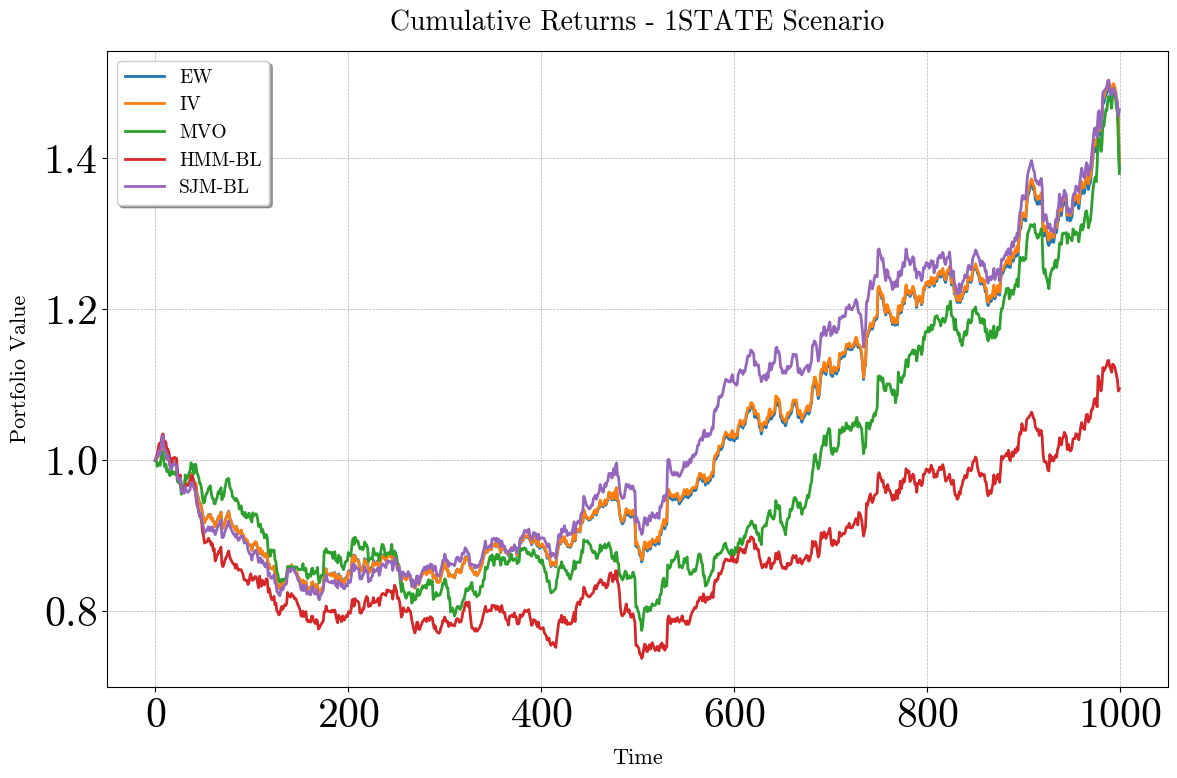

In [62]:
plt.rcParams['text.usetex'] = False
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 20,
    'axes.labelsize': 16,
    'legend.fontsize': 14,
})

# Choose one scenario to plot (e.g., "1state")
scenario = "1state"
_, pvs = sim_results[scenario]

plt.figure(figsize=(12, 8), dpi=100)
for strategy, pv in pvs.items():
    plt.plot(pv, linewidth=2, label=strategy)

plt.xlabel("Time", fontsize=16, labelpad=10)
plt.ylabel("Portfolio Value", fontsize=16, labelpad=10)
plt.title(f"Cumulative Returns - {scenario.upper()} Scenario", fontsize=20, pad=15)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend(loc="best", frameon=True, shadow=True)
plt.tight_layout()
plt.show()


In [63]:
# Retrieve the exact data used in model fitting
df_assets = simulate_1state_data(T_sim)

# Display the first few rows
print("Exact data used in model fitting:")
print(df_assets.head())

# Optionally, to view summary statistics:
print(df_assets.describe())





NameError: name 'T_sim' is not defined